In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [19]:
!sudo apt-get update
!sudo apt-get install -y xvfb ffmpeg freeglut3-dev
!pip install -q gym[classic_control]
!pip install -q tf-agents[reverb]
!pip install -q imageio
!pip install -q pyvirtualdisplay

Hit:1 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease
Hit:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Hit:3 https://r2u.stat.illinois.edu/ubuntu jammy InRelease                     
Hit:4 http://archive.ubuntu.com/ubuntu jammy InRelease                         
Hit:5 http://security.ubuntu.com/ubuntu jammy-security InRelease               
Hit:6 http://archive.ubuntu.com/ubuntu jammy-updates InRelease                 
Hit:7 http://archive.ubuntu.com/ubuntu jammy-backports InRelease
Hit:8 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:9 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:10 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Reading package lists... Done
W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry mis

In [23]:
import base64
import imageio
import IPython
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import pyvirtualdisplay

# Configuración de pantalla virtual
display = pyvirtualdisplay.Display(visible=0, size=(1400, 900))
display.start()

# --- CAMBIO: Importamos SAC y redes de distribución ---
from tf_agents.agents.sac import sac_agent
from tf_agents.agents.ddpg import critic_network
from tf_agents.drivers import dynamic_step_driver
from tf_agents.environments import suite_gym
from tf_agents.environments import tf_py_environment
from tf_agents.eval import metric_utils
from tf_agents.metrics import tf_metrics
from tf_agents.networks import actor_distribution_network # Necesario para SAC
from tf_agents.policies import random_tf_policy
from tf_agents.replay_buffers import tf_uniform_replay_buffer
from tf_agents.trajectories import trajectory
from tf_agents.specs import tensor_spec
from tf_agents.utils import common

# **Configuración de los Hiperparámetros** 

En este proceso, se definen las "reglas del juego" y la "personalidad" del agente antes de que empiece a estudiar.

Se define cuánto tiempo va a entrenar (iteraciones).

Se decide cuánta memoria va a tener para recordar sus errores y aciertos.

Se ajusta la velocidad a la que queremos que aprenda (ni muy rápido para no despistarse, ni muy lento para no tardar años).

Se establece cada cuánto tiempo vamos a hacerle un examen para ver si está mejorando.

In [26]:
num_iterations = 50000 

initial_collect_steps = 10000 # Recolectar mas experiencia inicial
collect_steps_per_iteration = 1
replay_buffer_max_length = 1000000

# Batch size más grande para mejor estabilidad en continuo
batch_size = 256

# Tasas de aprendizaje estándar para SAC
learning_rate_actor = 3e-4
learning_rate_critic = 3e-4
learning_rate_alpha = 3e-4

log_interval = 1000
num_eval_episodes = 10
eval_interval = 2000

# **Preparación del Entorno (El Mundo Virtual)**

En este proceso, se carga el simulador donde vivirá nuestro agente.

Se elige el "juego" o problema que queremos resolver (en este caso, el Péndulo).

Se crean dos copias del mundo: una para que el agente practique (entrenamiento) y otra para examinarlo (evaluación).

Se traduce este mundo a un formato que las herramientas de Inteligencia Artificial (TensorFlow) puedan entender.

Se revisa qué información nos da el mundo (observaciones) y qué movimientos permite hacer (acciones).

In [29]:
# Esta línea define el nombre del entorno que vamos a cargar.
env_name = 'Pendulum-v1'

# Esta línea carga el entorno para que el agente practique y aprenda.
train_py_env = suite_gym.load(env_name)

# Esta línea carga una copia separada del entorno solo para examinar al agente.
eval_py_env = suite_gym.load(env_name)

# Esta línea convierte el entorno de práctica a un formato compatible con TensorFlow.
train_env = tf_py_environment.TFPyEnvironment(train_py_env)

# Esta línea convierte el entorno de examen a un formato compatible con TensorFlow.
eval_env = tf_py_environment.TFPyEnvironment(eval_py_env)

# Esta línea muestra qué datos recibe el agente (posición, velocidad).
print('Observation Spec:', train_env.observation_spec())

# Esta línea muestra qué acciones puede tomar el agente (fuerza del torque).
print('Action Spec:', train_env.action_spec())

Observation Spec: BoundedTensorSpec(shape=(3,), dtype=tf.float32, name='observation', minimum=array([-1., -1., -8.], dtype=float32), maximum=array([1., 1., 8.], dtype=float32))
Action Spec: BoundedTensorSpec(shape=(1,), dtype=tf.float32, name='action', minimum=array(-2., dtype=float32), maximum=array(2., dtype=float32))


# **Construcción del Cerebro (Redes Neuronales)**

En este proceso, se crean las estructuras mentales del agente.

Se define el tamaño del cerebro, aumentando la cantidad de neuronas para que tenga mejor motricidad fina.

Se construye la red "Actor", que es la responsable de decidir qué acción tomar en cada momento.

Se construye la red "Crítico", que se encarga de juzgar si las acciones tomadas fueron buenas o malas.

In [30]:
fc_layer_params = (256, 256)

# 1. Red Actor (Distribución): Predice media y desviación estándar de la acción
actor_net = actor_distribution_network.ActorDistributionNetwork(
    train_env.observation_spec(),
    train_env.action_spec(),
    fc_layer_params=fc_layer_params,
    activation_fn=tf.keras.activations.relu)

# 2. Red Critic: Estima el valor Q (SAC usa esto igual que DDPG)
critic_net = critic_network.CriticNetwork(
    (train_env.observation_spec(), train_env.action_spec()),
    observation_fc_layer_params=None,
    action_fc_layer_params=fc_layer_params,
    joint_fc_layer_params=fc_layer_params,
    activation_fn=tf.keras.activations.relu)

# **Ensamblaje del Agente (El Jugador)**

En este proceso, se une todo para crear al agente completo.

Se configura el algoritmo SAC, que es el "cerebro" que usará las redes anteriores para aprender.

Se le asignan los optimizadores, que son las herramientas matemáticas para ajustar sus neuronas y mejorar.

Se preparan las políticas: una para recolectar datos explorando y otra para actuar cuando ya sabe qué hacer.

In [31]:
# Se normalizan las observaciones para ayudar a la red
tf_agent = sac_agent.SacAgent(
    train_env.time_step_spec(),
    train_env.action_spec(),
    actor_network=actor_net,
    critic_network=critic_net,
    actor_optimizer=tf.compat.v1.train.AdamOptimizer(learning_rate=learning_rate_actor),
    critic_optimizer=tf.compat.v1.train.AdamOptimizer(learning_rate=learning_rate_critic),
    alpha_optimizer=tf.compat.v1.train.AdamOptimizer(learning_rate=learning_rate_alpha),
    target_update_tau=0.005,
    target_update_period=1,
    td_errors_loss_fn=tf.compat.v1.losses.mean_squared_error,
    gamma=0.99,
    reward_scale_factor=1.0, # SAC maneja bien la escala natural
    train_step_counter=tf.Variable(0))

# Esta línea termina de configurar el agente para que esté listo.
tf_agent.initialize()

# Esta línea guarda la política principal que usaremos para evaluar al agente.
eval_policy = tf_agent.policy

# Esta línea guarda la política de recolección que usa el agente para explorar mientras aprende.
collect_policy = tf_agent.collect_policy

# **Configuración de la Memoria**

En este proceso, se prepara el sistema de almacenamiento de experiencias.

Se define una función auxiliar para calcular el promedio de notas del agente.

Se crea el "Buffer de Repetición", que es un almacén gigante donde se guardan todas las jugadas pasadas para repasarlas después.

In [32]:
# Función para calcular métricas
def compute_avg_return(environment, policy, num_episodes=10):
  total_return = 0.0
  for _ in range(num_episodes):

    time_step = environment.reset()
    episode_return = 0.0

    while not time_step.is_last():
      action_step = policy.action(time_step)
      time_step = environment.step(action_step.action)
      episode_return += time_step.reward
    total_return += episode_return

  avg_return = total_return / num_episodes
  return avg_return.numpy()[0]

# Crear el Replay Buffer
replay_buffer = tf_uniform_replay_buffer.TFUniformReplayBuffer(
    data_spec=tf_agent.collect_data_spec,
    batch_size=train_env.batch_size,
    max_length=replay_buffer_max_length)

# **Recolección Inicial de Datos**

En este proceso, se llena la memoria del agente antes de empezar el entrenamiento serio.

Se utiliza un "conductor" (driver) que mueve al agente por el mundo para acumular experiencias.

Se ejecuta la recolección inicial para tener datos base.

Se organiza la memoria en un formato eficiente para poder leerla rápidamente durante el entrenamiento.

In [33]:
# Driver para recolectar experiencias iniciales
collect_driver = dynamic_step_driver.DynamicStepDriver(
    train_env,
    collect_policy,
    observers=[replay_buffer.add_batch],
    num_steps=initial_collect_steps)

collect_driver.run()

# Crear dataset para entrenamiento
dataset = replay_buffer.as_dataset(
    num_parallel_calls=3,
    sample_batch_size=batch_size,
    num_steps=2).prefetch(3)

iterator = iter(dataset)

# **Bucle de Entrenamiento Principal**

En este proceso, ocurre el aprendizaje real del agente.

Se evalúa al agente antes de empezar para saber su nivel inicial.

Se entra en un ciclo repetitivo donde el agente alterna entre explorar un poco más y estudiar lo que ya vivió.

Se actualizan las redes neuronales usando los datos de la memoria.

Se imprime el progreso y se evalúa periódicamente para ver la mejora.

In [34]:
tf_agent.train = common.function(tf_agent.train)
tf_agent.train_step_counter.assign(0)

# Evaluamos antes de empezar
avg_return = compute_avg_return(eval_env, eval_policy, num_eval_episodes)
returns = [avg_return]
print(f'Retorno inicial (sin entrenar): {avg_return}')

for _ in range(num_iterations):

  # 1. Recolectar
  collect_driver = dynamic_step_driver.DynamicStepDriver(
    train_env,
    collect_policy,
    observers=[replay_buffer.add_batch],
    num_steps=collect_steps_per_iteration)
  collect_driver.run()

  # 2. Muestrear
  experience, _ = next(iterator)

  # 3. Entrenar
  train_loss = tf_agent.train(experience).loss

  step = tf_agent.train_step_counter.numpy()

  if step % log_interval == 0:
    print(f'step = {step}: loss = {train_loss}')

  if step % eval_interval == 0:
    avg_return = compute_avg_return(eval_env, eval_policy, num_eval_episodes)
    print(f'step = {step}: Average Return = {avg_return}')
    returns.append(avg_return)

Retorno inicial (sin entrenar): -1406.3399658203125


step = 1000: loss = 35.98866271972656
step = 2000: loss = 70.19097900390625
step = 2000: Average Return = -1313.79296875
step = 3000: loss = 163.27734375
step = 4000: loss = 160.87564086914062
step = 4000: Average Return = -1259.22900390625
step = 5000: loss = 114.9523696899414
step = 6000: loss = 155.01419067382812
step = 6000: Average Return = -1066.6448974609375
step = 7000: loss = 226.91339111328125
step = 8000: loss = 251.28521728515625
step = 8000: Average Return = -649.1473388671875
step = 9000: loss = 194.8329620361328
step = 10000: loss = 562.461181640625
step = 10000: Average Return = -307.006103515625
step = 11000: loss = 287.19873046875
step = 12000: loss = 701.5543212890625
step = 12000: Average Return = -178.71975708007812
step = 13000: loss = 251.07920837402344
step = 14000: loss = 443.53143310546875
step = 14000: Average Return = -210.84518432617188
step = 15000: loss = 367.25457763671875
step = 16000: loss = 575.3492431640625
step = 16000: Average Return = -136.6839752

# **Visualización de Resultados**

En este proceso, se generan gráficos para entender visualmente la evolución del agente.

Se crea un gráfico que muestra cómo ha cambiado la puntuación del agente a lo largo del tiempo.

Se interpreta la curva: si sube, significa que el agente está aprendiendo a mantener el péndulo arriba.

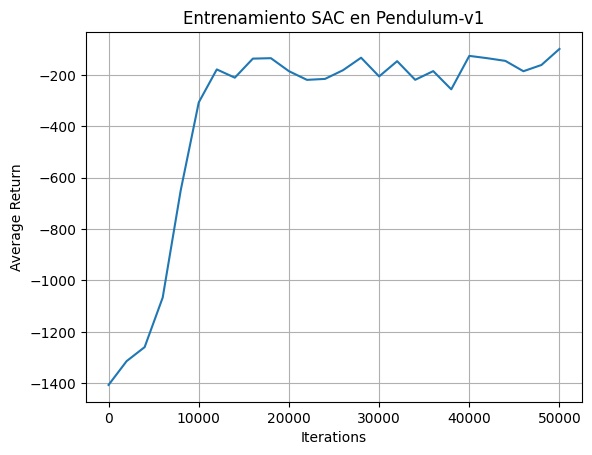

In [35]:
iterations = range(0, num_iterations + 1, eval_interval)
plt.plot(iterations, returns)
plt.ylabel('Average Return')
plt.xlabel('Iterations')
plt.title("Entrenamiento SAC en Pendulum-v1")
plt.grid(True)
plt.show()

El inicio : La línea empieza muy abajo (valores muy negativos, como -1500). Esto significa que al principio el agente no sabía nada y el péndulo se caía o giraba sin control.

La subida : Vemos que la línea sube rápidamente. Este es el momento donde el agente descubre la técnica para levantar el péndulo y empieza a ganar mejores puntos.

# **Generación del Video Final**

En este proceso, se graba al agente en acción para verificar visualmente su comportamiento.

Se define una función para grabar varios intentos del agente y guardarlos en un archivo de video.

Se define otra función para incrustar ese video dentro de este cuaderno y poder verlo aquí mismo.

Se ejecuta la grabación y se muestra el resultado final.

In [36]:
# Función para crear el video (igual que antes)
def create_policy_eval_video(policy, filename, num_episodes=5, fps=30):
  filename = filename + ".mp4"
  with imageio.get_writer(filename, fps=fps) as video:
    for _ in range(num_episodes):
      time_step = eval_env.reset()
      # Renderiza el primer frame
      video.append_data(eval_py_env.render())
      while not time_step.is_last():
        action_step = policy.action(time_step)
        time_step = eval_env.step(action_step.action)
        # Renderiza frames siguientes
        video.append_data(eval_py_env.render())
  return filename

# --- NUEVA FUNCIÓN PARA VISUALIZAR EL VIDEO ---
def embed_mp4(filename):
  """Incrusta un archivo MP4 en el cuaderno usando HTML y Base64."""
  video = open(filename, 'rb').read()
  b64 = base64.b64encode(video)
  tag = '''
  <video width="640" height="480" controls>
    <source src="data:video/mp4;base64,{0}" type="video/mp4">
  Your browser does not support the video tag.
  </video>'''.format(b64.decode())

  return IPython.display.HTML(tag)
# -----------------------------------------------

# 1. Generar el archivo de video
video_filename = create_policy_eval_video(eval_policy, "trained-agent")

# 2. Mostrar el video en el cuaderno
print(f"Video guardado como: {video_filename}")
embed_mp4(video_filename)

Video guardado como: trained-agent.mp4
